In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
train = pd.read_csv('Concours Kaggle/Surpoids_Multiclasse/train.csv')
test = pd.read_csv('Concours Kaggle/Surpoids_Multiclasse/test.csv')
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


# Correlation

In [19]:
train['Gender'] = train['Gender'].replace({'Male' : 0, 'Female' : 1})
train['family_history_with_overweight'] = train['family_history_with_overweight'].replace({'yes' : 1, 'no' : 0})
train['FAVC'] = train['FAVC'].replace({'yes' : 1, 'no' : 0})
train['SMOKE'] = train['SMOKE'].replace({'yes' : 1, 'no' : 0})
train['SCC'] = train['SCC'].replace({'yes' : 1, 'no' : 0})
train['CAEC'] = train['CAEC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
train['CALC'] = train['CALC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
train['NObeyesdad'] = train['NObeyesdad'].replace({'Insufficient_Weight' : 0, 'Normal_Weight' : 1, 'Overweight_Level_I' : 2, 'Overweight_Level_II' : 3, 'Obesity_Type_I' : 4, 'Obesity_Type_II' : 5, 'Obesity_Type_III' : 6})
train['MTRANS'] = train['MTRANS'].replace({'Public_Transportation' : 0, 'Automobile' : 1, 'Motorbike' : 2, 'Bike' : 3, 'Walking' : 4})

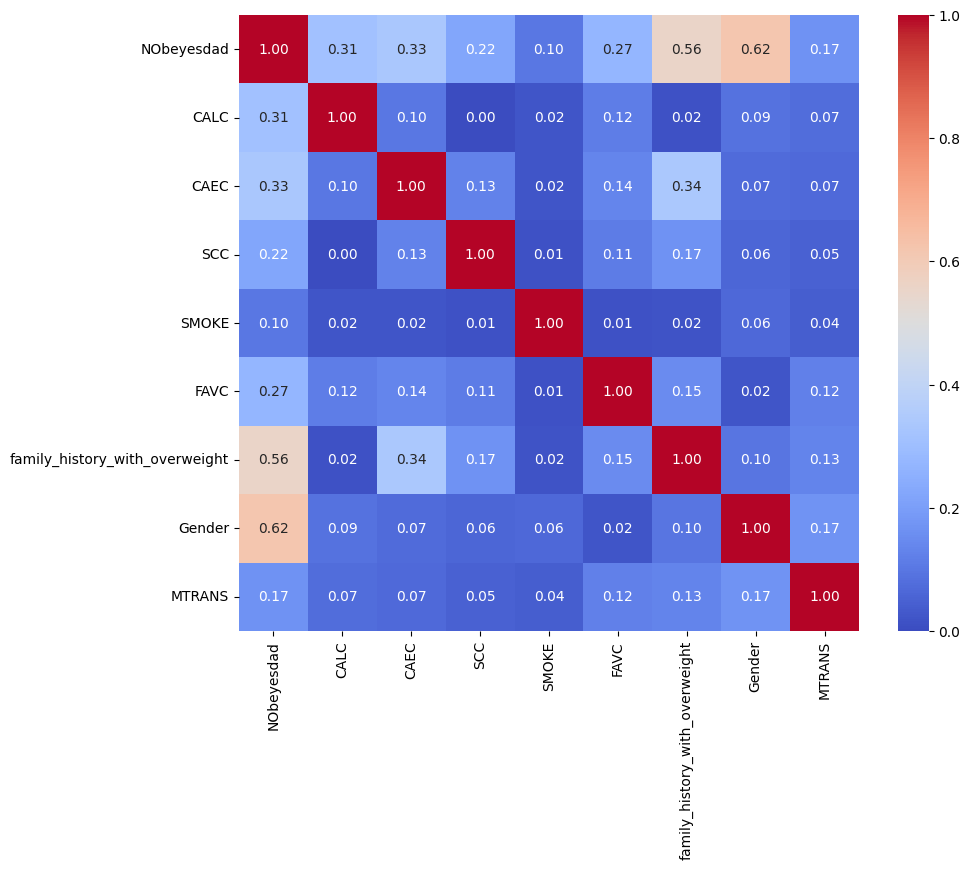

In [20]:
import numpy as np
from scipy.stats import chi2_contingency

# nous utilisons le V de cramer car nos observations sont ici qualitative et indépendante et nous avons une matrice
# carré 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cols = ['NObeyesdad','CALC','CAEC','SCC','SMOKE','FAVC','family_history_with_overweight','Gender', 'MTRANS']
cramers_v_matrix = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

import seaborn as sns
import matplotlib.pyplot as plt

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# les coefficient avec 2 fois la même variable ne sont pas à 1 car nous avons une correction de la continuité pour
# faire face au sous effectif dans certaines cases de la matrice de contingence

# Random forest multiclass

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Séparer les caractéristiques et la variable cible
X = train.iloc[:, :-1]  # toutes les colonnes sauf la dernière
y = train.iloc[:, -1]   # la dernière colonne

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle de forêt aléatoire
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf.fit(X_train, y_train)

# Évaluer le modèle
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.95      0.92      0.93       524
           1       0.84      0.88      0.86       626
           2       0.76      0.74      0.75       484
           3       0.79      0.80      0.79       514
           4       0.89      0.87      0.88       543
           5       0.97      0.97      0.97       657
           6       1.00      1.00      1.00       804

    accuracy                           0.89      4152
   macro avg       0.88      0.88      0.88      4152
weighted avg       0.89      0.89      0.89      4152



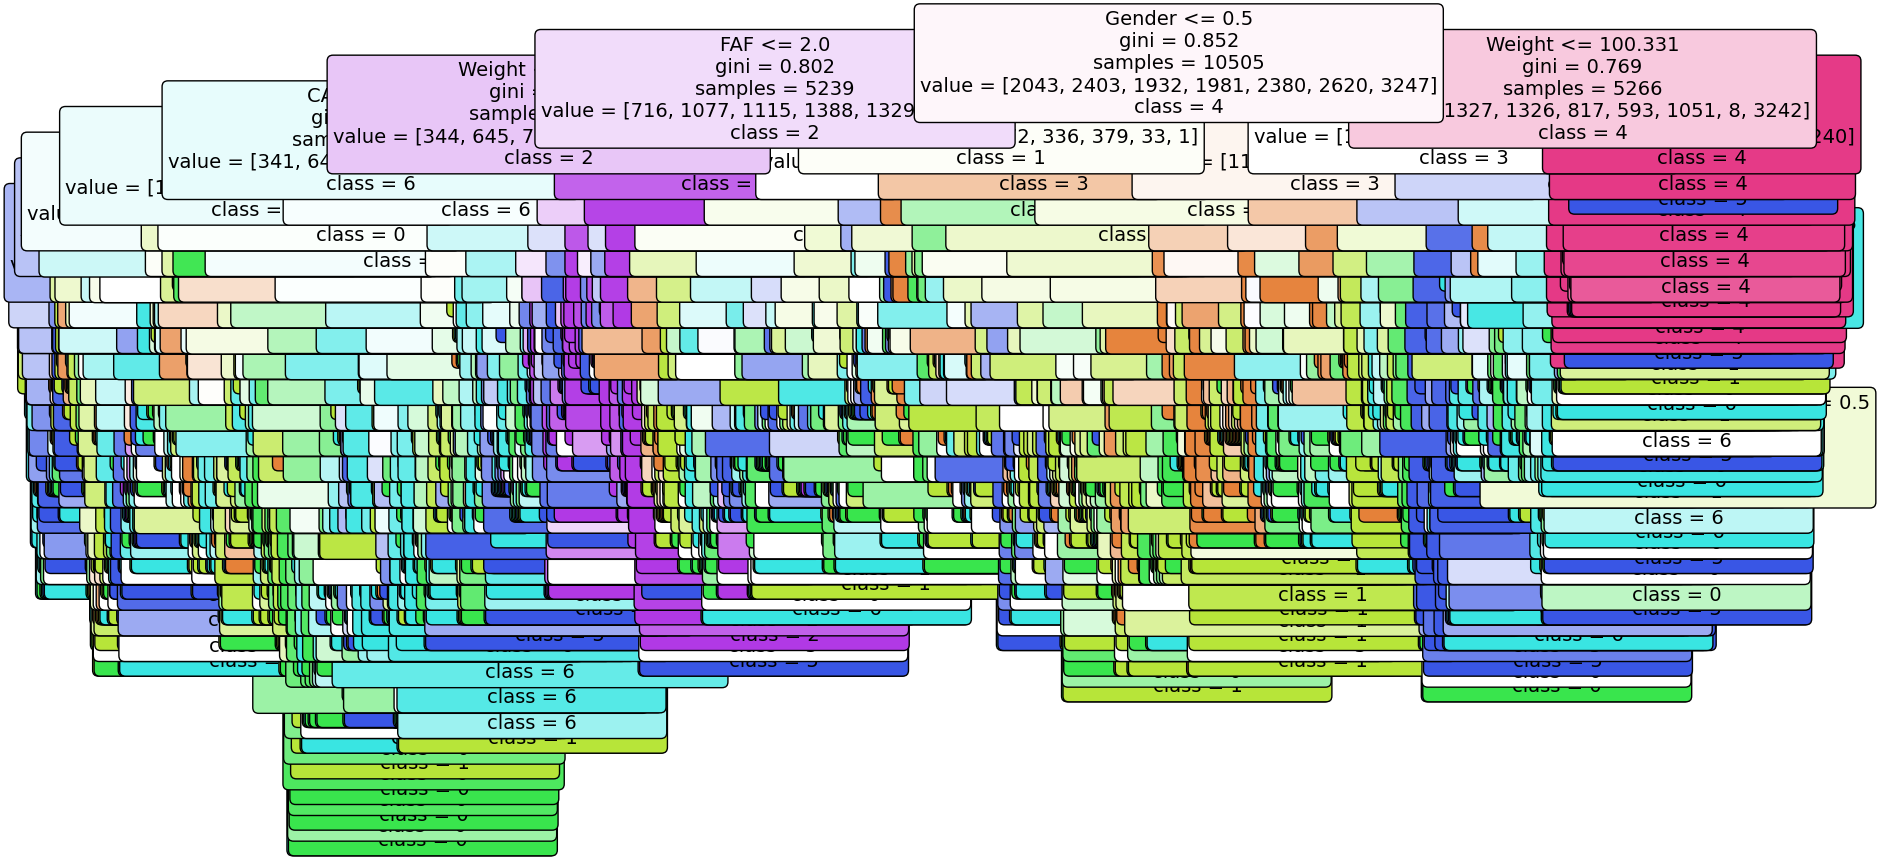

In [22]:
# Affichage Arbre 

from sklearn import tree
import matplotlib.pyplot as plt

# Sélectionnez un arbre spécifique
estimator = rf.estimators_[5]

plt.figure(figsize=(20,10))
class_names = [str(i) for i in y.unique()]

tree.plot_tree(estimator, 
               feature_names=X.columns, 
               class_names=class_names, 
               filled=True, 
               rounded=True, 
               fontsize=14)
plt.show()

In [130]:
test['Gender'] = test['Gender'].replace({'Male' : 0, 'Female' : 1})
test['family_history_with_overweight'] = test['family_history_with_overweight'].replace({'yes' : 1, 'no' : 0})
test['FAVC'] = test['FAVC'].replace({'yes' : 1, 'no' : 0})
test['SMOKE'] = test['SMOKE'].replace({'yes' : 1, 'no' : 0})
test['SCC'] = test['SCC'].replace({'yes' : 1, 'no' : 0})
test['CAEC'] = test['CAEC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
test['CALC'] = test['CALC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
test['MTRANS'] = test['MTRANS'].replace({'Public_Transportation' : 0, 'Automobile' : 1, 'Motorbike' : 2, 'Bike' : 3, 'Walking' : 4})

In [24]:
predictions2 = rf.predict(test)

In [25]:
predictions2

array([5, 2, 6, ..., 0, 1, 5])

In [26]:
# Réinitialiser l'index de l'ensemble de test pour correspondre aux prédictions
X_test_reset = test.reset_index(drop=True)

# Convertir les prédictions en une série pandas et l'ajouter au DataFrame de test réinitialisé
X_test_reset['predictions'] = pd.Series(predictions2)

# Si nécessaire, vous pouvez maintenant rejoindre cette nouvelle DataFrame avec le DataFrame d'origine
# Pour ce faire, nous devons d'abord réinitialiser l'index du DataFrame d'origine avant la division
df_original_reset = test.reset_index(drop=True)

# Joindre les deux DataFrames sur l'index
df_with_predictions = df_original_reset.join(X_test_reset['predictions'], how='right')


In [27]:
df_with_predictions

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,predictions
0,20758,0,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,1,0,2.825629,0,0.855400,0.000000,1,0,5
1,20759,1,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,1,0,3.000000,0,1.000000,0.000000,1,0,2
2,20760,1,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,1,0,2.621877,0,0.000000,0.250502,1,0,6
3,20761,0,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,1,0,2.786417,0,0.094851,0.000000,1,0,4
4,20762,1,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,1,0,2.653531,0,0.000000,0.741069,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,0,23.327836,1.721384,78.030383,1,0,2.813234,3.000000,1,0,1.000000,0,0.807076,0.778632,1,0,3
13836,34594,1,29.000000,1.590000,62.000000,0,1,3.000000,3.000000,1,0,2.000000,0,0.000000,0.000000,1,0,2
13837,34595,1,22.935612,1.585547,44.376637,0,1,3.000000,2.273740,2,0,2.000000,0,1.949840,1.000000,1,0,0
13838,34596,0,21.000000,1.620000,53.000000,1,1,2.000000,3.000000,1,0,2.000000,0,3.000000,2.000000,0,0,1


In [28]:
df_with_predictions['predictions'] = df_with_predictions['predictions'].replace({0 : 'Insufficient_Weight', 1 : 'Normal_Weight', 2 : 'Overweight_Level_I', 3 : 'Overweight_Level_II', 4 : 'Obesity_Type_I', 5 : 'Obesity_Type_II', 6 : 'Obesity_Type_III'})

In [29]:
dfVrai = df_with_predictions[['id', 'predictions']]
dfVrai = dfVrai.rename(columns={'predictions': 'NObeyesdad'})

In [30]:
dfVrai

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [31]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
dfVrai.to_csv('output.csv', index=False)

# Arbre de boosting adaptatif (AdaBoost)

In [34]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,0,3
1,1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,1,1
2,2,1,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,0,0
3,3,1,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,0,6
4,4,0,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,0,3


In [112]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Séparez les caractéristiques et la cible
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Créez et entraînez le modèle AdaBoost
model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Évaluez le modèle
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5332369942196532


# Arbre de décision Cart

In [110]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Séparez les caractéristiques et la cible
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Créez et entraînez le modèle CART
model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5
)
model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Évaluez le modèle
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8706647398843931


# Vote mojoritaire des 3 modèle


              precision    recall  f1-score   support

           0       0.95      0.92      0.93       524
           1       0.85      0.88      0.87       626
           2       0.78      0.76      0.77       484
           3       0.79      0.81      0.80       514
           4       0.89      0.87      0.88       543
           5       0.97      0.97      0.97       657
           6       1.00      1.00      1.00       804

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



In [140]:
from sklearn.ensemble import VotingClassifier

# Créez les trois modèles
model1 = RandomForestClassifier(n_estimators=100)
model2 = AdaBoostClassifier(n_estimators=100)
model3 = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5
)
model4 = RandomForestClassifier(n_estimators=500)

# Créez le modèle de vote
model = VotingClassifier(estimators=[('rf', model1), ('ab', model2), ('dt', model3), ('er', model4)], voting='hard')

# Entraînez le modèle de vote
model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Évaluez le modèle
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8913776493256262


In [142]:
# réponse commune 
# Entraînez chaque modèle
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)

# Faites des prédictions avec chaque modèle
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)

# Calculez le ratio de réponses communes
common_predictions12 = sum(predictions1 == predictions2) / len(predictions1)
common_predictions13 = sum(predictions1 == predictions3) / len(predictions1)
common_predictions23 = sum(predictions2 == predictions3) / len(predictions2)

print(f'Ratio de réponses communes entre model1 et model2: {common_predictions12}')
print(f'Ratio de réponses communes entre model1 et model3: {common_predictions13}')
print(f'Ratio de réponses communes entre model2 et model3: {common_predictions23}')

# Trouvez les prédictions incorrectes pour chaque modèle
incorrect_predictions1 = predictions1 != y_test
incorrect_predictions2 = predictions2 != y_test
incorrect_predictions3 = predictions3 != y_test

# Calculez le ratio de corrections pour chaque paire de modèles
corrections12 = sum(incorrect_predictions1 & ~incorrect_predictions2) / sum(incorrect_predictions1)
corrections13 = sum(incorrect_predictions1 & ~incorrect_predictions3) / sum(incorrect_predictions1)
corrections21 = sum(incorrect_predictions2 & ~incorrect_predictions1) / sum(incorrect_predictions2)
corrections23 = sum(incorrect_predictions2 & ~incorrect_predictions3) / sum(incorrect_predictions2)
corrections31 = sum(incorrect_predictions3 & ~incorrect_predictions1) / sum(incorrect_predictions3)
corrections32 = sum(incorrect_predictions3 & ~incorrect_predictions2) / sum(incorrect_predictions3)

print(f'Ratio de corrections de model2 sur model1: {corrections12}')
print(f'Ratio de corrections de model3 sur model1: {corrections13}')
print(f'Ratio de corrections de model1 sur model2: {corrections21}')
print(f'Ratio de corrections de model3 sur model2: {corrections23}')
print(f'Ratio de corrections de model1 sur model3: {corrections31}')
print(f'Ratio de corrections de model2 sur model3: {corrections32}')

Ratio de réponses communes entre model1 et model2: 0.45688824662813105
Ratio de réponses communes entre model1 et model3: 0.8935452793834296
Ratio de réponses communes entre model2 et model3: 0.43858381502890176
Ratio de corrections de model2 sur model1: 0.30751708428246016
Ratio de corrections de model3 sur model1: 0.2460136674259681
Ratio de corrections de model1 sur model2: 0.8709129511677283
Ratio de corrections de model3 sur model2: 0.8428874734607219
Ratio de corrections de model1 sur model3: 0.46353322528363045
Ratio de corrections de model2 sur model3: 0.40032414910858993


In [146]:
from scipy import stats

test2 = test

test2 = test2.drop(columns=['combined_predictions'])
# Faites des prédictions avec chaque modèle sur les données d'entraînement
predictions1_train = model1.predict(test2)
predictions3_train = model3.predict(test2)
predictions4_train = model4.predict(test2)

# Combine les prédictions
combined_predictions_train = stats.mode(np.array([predictions1_train, predictions3_train, predictions4_train]), axis=0)[0]

# Ajoutez les prédictions combinées à votre DataFrame d'entraînement
test2['combined_predictions'] = combined_predictions_train


In [147]:
test2.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,combined_predictions
0,20758,0,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,1,0,2.825629,0,0.855400,0.000000,1,0,5
1,20759,1,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,1,0,3.000000,0,1.000000,0.000000,1,0,2
2,20760,1,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,1,0,2.621877,0,0.000000,0.250502,1,0,6
3,20761,0,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,1,0,2.786417,0,0.094851,0.000000,1,0,4
4,20762,1,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,1,0,2.653531,0,0.000000,0.741069,1,0,6


In [148]:
test2['combined_predictions'] = test2['combined_predictions'].replace({0 : 'Insufficient_Weight', 1 : 'Normal_Weight', 2 : 'Overweight_Level_I', 3 : 'Overweight_Level_II', 4 : 'Obesity_Type_I', 5 : 'Obesity_Type_II', 6 : 'Obesity_Type_III'})

In [149]:
dfVrai = test2[['id', 'combined_predictions']]
dfVrai = dfVrai.rename(columns={'predictions': 'NObeyesdad'})
dfVrai.to_csv('output2.csv', index=False)

faire un modele qui rassemble les modele plus performant 

1/4 contexte - sujet 
- correlation / analyse descriptive / ce qu'on pense avant de faire les modèles 
- modele / resultat 


- resultat qu'on a sur kaggle 
- parler 

(Canva / power point / Format : A0)